In [1]:
import pandas as pd

#### **Idea**
Investigate how motor fluctuations (differences between ON and OFF medication states) evolve over time and what early patterns predict their worsening.

In [ ]:
#Loadin
motor_data = pd.read_csv('/Users/larsheijnen/Thesis/data/motor/MDS-UPDRS_Part_III_21Mar2025.csv')

In [ ]:
# Checking columns
motor_data.columns

Index(['REC_ID', 'PATNO', 'EVENT_ID', 'PAG_NAME', 'INFODT', 'PDTRTMNT',
       'PDSTATE', 'HRPOSTMED', 'HRDBSON', 'HRDBSOFF', 'PDMEDYN', 'DBSYN',
       'ONOFFORDER', 'OFFEXAM', 'OFFNORSN', 'DBSOFFTM', 'ONEXAM', 'ONNORSN',
       'HIFUYN', 'DBSONTM', 'PDMEDDT', 'PDMEDTM', 'EXAMDT', 'EXAMTM',
       'NP3SPCH', 'NP3FACXP', 'NP3RIGN', 'NP3RIGRU', 'NP3RIGLU', 'NP3RIGRL',
       'NP3RIGLL', 'NP3FTAPR', 'NP3FTAPL', 'NP3HMOVR', 'NP3HMOVL', 'NP3PRSPR',
       'NP3PRSPL', 'NP3TTAPR', 'NP3TTAPL', 'NP3LGAGR', 'NP3LGAGL', 'NP3RISNG',
       'NP3GAIT', 'NP3FRZGT', 'NP3PSTBL', 'NP3POSTR', 'NP3BRADY', 'NP3PTRMR',
       'NP3PTRML', 'NP3KTRMR', 'NP3KTRML', 'NP3RTARU', 'NP3RTALU', 'NP3RTARL',
       'NP3RTALL', 'NP3RTALJ', 'NP3RTCON', 'NP3TOT', 'DYSKPRES', 'DYSKIRAT',
       'NHY', 'ORIG_ENTRY', 'LAST_UPDATE'],
      dtype='object')

In [ ]:
# Checkking PDSTATE options
motor_data['PDSTATE'].unique()

array([nan, 'ON', 'OFF'], dtype=object)

In [ ]:
# Group
motor_data.groupby(['PATNO', 'INFODT', 'PDSTATE']).size().unstack(fill_value=0).head(10)

PDSTATE        OFF  ON
PATNO INFODT          
3001  03/2018    1   1
      03/2019    1   1
      03/2023    1   1
      04/2014    0   1
      04/2015    1   1
      06/2016    1   1
      07/2022    1   1
      09/2013    0   1
      09/2015    0   1
      09/2021    1   1

In [ ]:
#Go on with the relevant columns
motor_fluct = motor_data[['PATNO', 'INFODT', 'PDSTATE', 'NP3TOT', 'HRPOSTMED']].copy()
motor_fluct = motor_fluct.dropna(subset=['PDSTATE', 'NP3TOT'])

In [ ]:
# Create a pivot table from the 'motor_fluct' DataFrame
pivoted = motor_fluct.pivot_table(
    index=['PATNO', 'INFODT'],   # Set 'PATNO' (patient number) and 'INFODT' (info date) as the row index
    columns='PDSTATE',           # Set 'PDSTATE' (probably the motor state, like ON/OFF) as the columns
    values='NP3TOT'              # Use 'NP3TOT' (maybe a score like UPDRS Part III total) as the cell values
).reset_index()                  # Reset the index to turn 'PATNO' and 'INFODT' back into regular columns

In [26]:
pivoted = pivoted.dropna(subset=['ON', 'OFF'])


pivoted['ON_OFF_DIFF'] = pivoted['OFF'] - pivoted['ON']

on_hrpostmed = motor_fluct[motor_fluct['PDSTATE'] == 'ON'][['PATNO', 'INFODT', 'HRPOSTMED']]
on_hrpostmed = on_hrpostmed.groupby(['PATNO', 'INFODT'])['HRPOSTMED'].first().reset_index()

pivoted = pivoted.merge(on_hrpostmed, on=['PATNO', 'INFODT'], how='left')

# Preview result
pivoted.head()

,PATNO,INFODT,OFF,ON,ON_OFF_DIFF,HRPOSTMED
0,3001,03/2018,36.0,25.0,11.0,0.9167
1,3001,04/2015,39.0,35.0,4.0,2.0000
2,3001,06/2016,34.0,26.0,8.0,1.4000
3,3001,09/2021,58.0,40.0,18.0,1.0000
4,3002,03/2014,31.0,24.0,7.0,1.3333


In [27]:
pivoted['INFODT'] = pd.to_datetime(pivoted['INFODT'], errors='coerce')

/var/folders/kw/d3zgy6jx0gl0lybbg494yl8c0000gn/T/ipykernel_18021/214148996.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  pivoted['INFODT'] = pd.to_datetime(pivoted['INFODT'], errors='coerce')


In [28]:
pivoted.head()

,PATNO,INFODT,OFF,ON,ON_OFF_DIFF,HRPOSTMED
0,3001,2018-03-01,36.0,25.0,11.0,0.9167
1,3001,2015-04-01,39.0,35.0,4.0,2.0000
2,3001,2016-06-01,34.0,26.0,8.0,1.4000
3,3001,2021-09-01,58.0,40.0,18.0,1.0000
4,3002,2014-03-01,31.0,24.0,7.0,1.3333


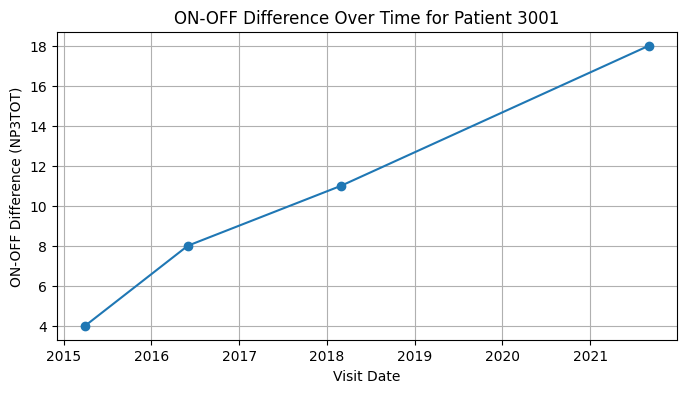

In [30]:
import matplotlib.pyplot as plt

patno = 3001
patient_data = pivoted[pivoted['PATNO'] == patno].sort_values('INFODT')

plt.figure(figsize=(8, 4))
plt.plot(patient_data['INFODT'], patient_data['ON_OFF_DIFF'], marker='o')
plt.title(f'ON-OFF Difference Over Time for Patient {patno}')
plt.xlabel('Visit Date')
plt.ylabel('ON-OFF Difference (NP3TOT)')
plt.grid(True)
plt.show()

In [31]:
from scipy.stats import linregress

def compute_slope(df):
    # Drop missing dates
    df = df.dropna(subset=['INFODT', 'ON_OFF_DIFF'])
    if len(df) < 2:
        return None
    # Convert dates to ordinal for regression
    x = df['INFODT'].map(pd.Timestamp.toordinal)
    y = df['ON_OFF_DIFF']
    slope, intercept, r_value, p_value, std_err = linregress(x, y)
    return slope

# Compute slope for each patient
slopes = pivoted.groupby('PATNO').apply(compute_slope).dropna()
slopes = slopes.rename('ON_OFF_DIFF_slope').reset_index()

# Preview: patients with most rapidly increasing fluctuations
slopes.sort_values('ON_OFF_DIFF_slope', ascending=False).head()

/var/folders/kw/d3zgy6jx0gl0lybbg494yl8c0000gn/T/ipykernel_18021/2344955342.py:15: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  slopes = pivoted.groupby('PATNO').apply(compute_slope).dropna()


,PATNO,ON_OFF_DIFF_slope
418,50485,0.110778
238,3914,0.103967
741,245552,0.076087
729,239728,0.061475
721,226669,0.060109


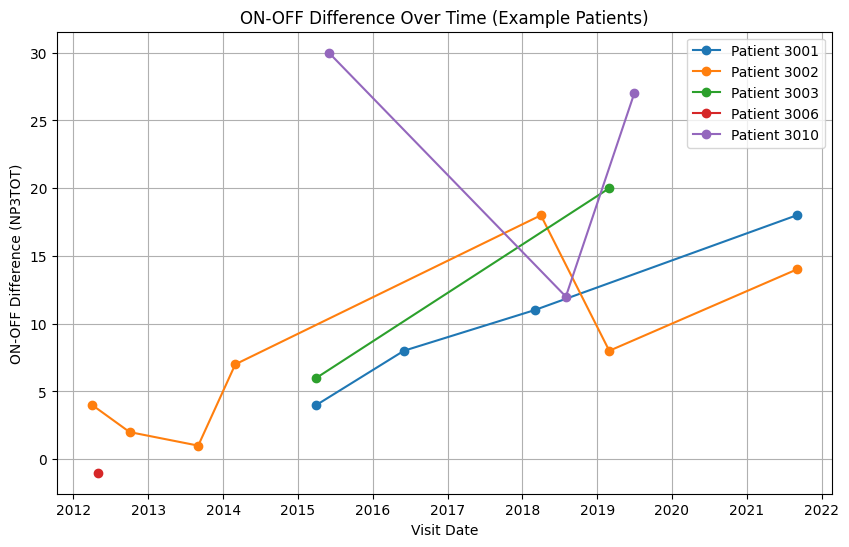

In [32]:
example_patients = pivoted['PATNO'].unique()[:5]  # First 5 patients

plt.figure(figsize=(10, 6))
for patno in example_patients:
    patient_data = pivoted[pivoted['PATNO'] == patno].sort_values('INFODT')
    plt.plot(patient_data['INFODT'], patient_data['ON_OFF_DIFF'], marker='o', label=f'Patient {patno}')
plt.xlabel('Visit Date')
plt.ylabel('ON-OFF Difference (NP3TOT)')
plt.title('ON-OFF Difference Over Time (Example Patients)')
plt.legend()
plt.grid(True)
plt.show()

Correlation between first and last ON-OFF difference: 0.42


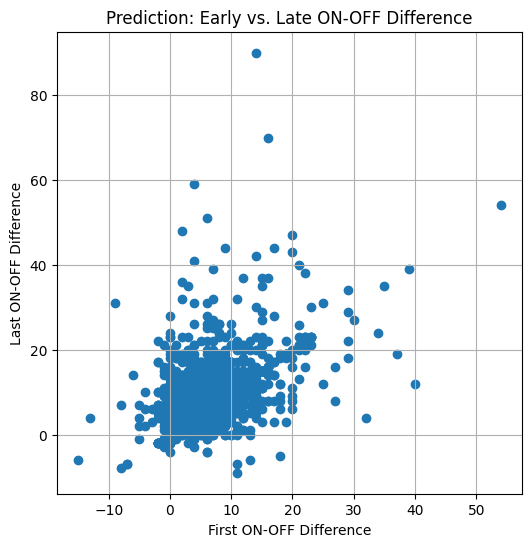

In [34]:
# Get first and last ON_OFF_DIFF for each patient
first_last = pivoted.sort_values('INFODT').groupby('PATNO')['ON_OFF_DIFF'].agg(['first', 'last']).dropna()

# Simple correlation
correlation = first_last['first'].corr(first_last['last'])
print(f"Correlation between first and last ON-OFF difference: {correlation:.2f}")

# Scatter plot
plt.figure(figsize=(6, 6))
plt.scatter(first_last['first'], first_last['last'])
plt.xlabel('First ON-OFF Difference')
plt.ylabel('Last ON-OFF Difference')
plt.title('Prediction: Early vs. Late ON-OFF Difference')
plt.grid(True)
plt.show()

/var/folders/kw/d3zgy6jx0gl0lybbg494yl8c0000gn/T/ipykernel_18021/3627336118.py:15: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  slopes = pivoted.groupby('PATNO').apply(compute_slope).dropna()


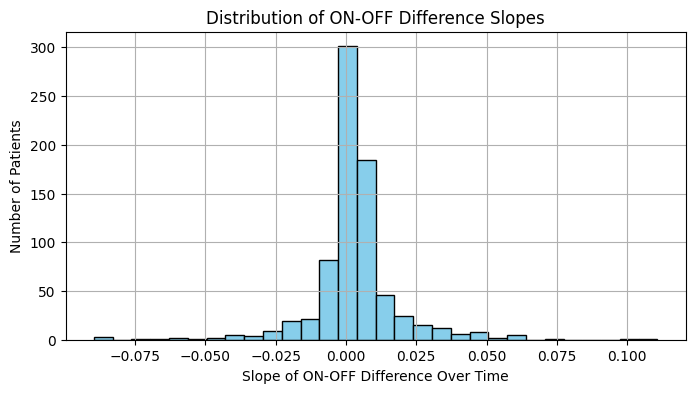

Mean slope: 0.003184614654102481
Median slope: 0.002293479755661831
Proportion with increasing difference: 0.66005291005291


In [36]:
from scipy.stats import linregress
import matplotlib.pyplot as plt

# Function to compute the slope of ON_OFF_DIFF over time for each patient
def compute_slope(df):
    df = df.dropna(subset=['INFODT', 'ON_OFF_DIFF'])
    if len(df) < 2:
        return None
    x = df['INFODT'].map(pd.Timestamp.toordinal)
    y = df['ON_OFF_DIFF']
    slope, intercept, r_value, p_value, std_err = linregress(x, y)
    return slope

# Calculate slope for each patient
slopes = pivoted.groupby('PATNO').apply(compute_slope).dropna()
slopes = slopes.rename('ON_OFF_DIFF_slope').reset_index()

# Visualize the distribution of slopes
plt.figure(figsize=(8, 4))
plt.hist(slopes['ON_OFF_DIFF_slope'], bins=30, color='skyblue', edgecolor='black')
plt.xlabel('Slope of ON-OFF Difference Over Time')
plt.ylabel('Number of Patients')
plt.title('Distribution of ON-OFF Difference Slopes')
plt.grid(True)
plt.show()

# Print summary statistics
print("Mean slope:", slopes['ON_OFF_DIFF_slope'].mean())
print("Median slope:", slopes['ON_OFF_DIFF_slope'].median())
print("Proportion with increasing difference:", (slopes['ON_OFF_DIFF_slope'] > 0).mean())